In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = "../dataset/cifar-10-batches-py"

In [15]:
class CUDADataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        
    def __iter__(self):
        for images, labels in self.dataloader:
            yield [images.to(device), labels.to(device)]
            
    def __len__(self):
        return len(self.dataloader)
    
    @property
    def dataset(self):
        return self.dataloader.dataset

In [17]:
class CIFAR10Dataset:
    def __init__(self, dataset='train', path=PATH):
        path = Path(path)
        if dataset == 'train':
            batches = [self.load_batch(p) for p in path.glob('data_batch_*')]
            self.images = torch.cat([b for b, _ in batches])
            self.labels = torch.cat([b for _, b in batches])
        elif dataset == 'test':
            self.images, self.labels = self.load_batch(path / 'test_batch')
            
        # normalize
        self.images = self.images.float()
        self.labels = self.labels.long()
        
        std, mean = torch.std_mean(self.images, dim=0)
        self.images = (self.images - mean) / std
        
        assert len(self.images) == len(self.labels)
    
    def load_batch(self, path):
        with open(path, 'rb') as file:
            data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data'].reshape((-1, 32, 32, 3), order='F').swapaxes(1,2)
        images = torch.from_numpy(images)
        labels = torch.Tensor(data_dict[b'labels'])
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [16]:
train_dataset = CIFAR10Dataset('train',PATH)
test_dataset = CIFAR10Dataset('test',PATH)

train_dataloader = CUDADataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True))
test_dataloader = CUDADataLoader(DataLoader(test_dataset, batch_size=1_024, pin_memory=True))

In [24]:
def train(model, dataloader, optimizer, odecay):
    for image_batch, label_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(image_batch)
        #Compute Loss
        oloss =  l2_reg_ortho(model)
        oloss =  odecay * oloss        
        
        loss = F.cross_entropy(predictions, label_batch)
        loss = loss + oloss
        loss.backward()
        optimizer.step()

def predict(model, images):
    predictions = model(images)
    predictions = torch.argmax(predictions, dim=1)
    return predictions

def accuracy(model, dataloader):
    hits = num_batches = 0
    for image_batch, label_batch in dataloader:
        predictions = predict(model, image_batch)
        hits += (predictions == label_batch).count_nonzero()
        
    return hits / len(dataloader.dataset)

In [19]:
def MLPClassifier(input_size, output_size, num_neurons, activation_type=nn.ReLU, initializer=None):
    layers = [nn.Flatten(1)]
    last_layer_neurons = input_size

    for i, layer_neurons in enumerate(num_neurons):
        layer = nn.Linear(last_layer_neurons, layer_neurons)
        
        if initializer is not None:
            initializer(layer.weight)
        
        layers.append(layer)
        layers.append(activation_type())
        last_layer_neurons = layer_neurons

    layers.append(nn.Linear(last_layer_neurons, output_size))
    return nn.Sequential(*layers)

In [20]:
"""Function used for Orthogonal Regularization"""
def l2_reg_ortho(mdl):
    l2_reg = None
    for W in mdl.parameters():
        if W.ndimension() < 2:
            continue
        else:
            cols = W[0].numel()
            rows = W.shape[0]
            w1 = W.view(-1,cols)
            wt = torch.transpose(w1,0,1)
            if (rows > cols):
                m  = torch.matmul(wt,w1)
                ident = Variable(torch.eye(cols,cols),requires_grad=True)
            else:
                m = torch.matmul(w1,wt)
                ident = Variable(torch.eye(rows,rows), requires_grad=True)

            ident = ident.cuda()
            w_tmp = (m - ident)
            b_k = Variable(torch.rand(w_tmp.shape[1],1))
            b_k = b_k.cuda()

            v1 = torch.matmul(w_tmp, b_k)
            norm1 = torch.norm(v1,2)
            v2 = torch.div(v1,norm1)
            v3 = torch.matmul(w_tmp,v2)

            if l2_reg is None:
                l2_reg = (torch.norm(v3,2))**2
            else:
                l2_reg = l2_reg + (torch.norm(v3,2))**2
    return l2_reg

# We try some different lambda value with different scale, and we found that the  when lambda is around (n)e-2 could get a decent result

In [39]:
num_neurons = (512, 512)
model = MLPClassifier(32*32*3, 10, num_neurons).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.95))

accuracies = np.zeros(25)

for epoch in range(25):
    odecay = 1e-2
    train(model, train_dataloader, optimizer, odecay)
    accuracies[epoch] = accuracy(model, test_dataloader)
    print(f"{epoch=:<2} acc={accuracies[epoch]:.4f}")

epoch=0  acc=0.2668
epoch=1  acc=0.2993
epoch=2  acc=0.3064
epoch=3  acc=0.3358
epoch=4  acc=0.3312
epoch=5  acc=0.3398
epoch=6  acc=0.3599
epoch=7  acc=0.3524
epoch=8  acc=0.3538
epoch=9  acc=0.3625
epoch=10 acc=0.3661
epoch=11 acc=0.3773
epoch=12 acc=0.3782
epoch=13 acc=0.3777
epoch=14 acc=0.3684
epoch=15 acc=0.3772
epoch=16 acc=0.3639
epoch=17 acc=0.3684
epoch=18 acc=0.4009
epoch=19 acc=0.3494
epoch=20 acc=0.3739
epoch=21 acc=0.3635
epoch=22 acc=0.3810
epoch=23 acc=0.3999
epoch=24 acc=0.3908


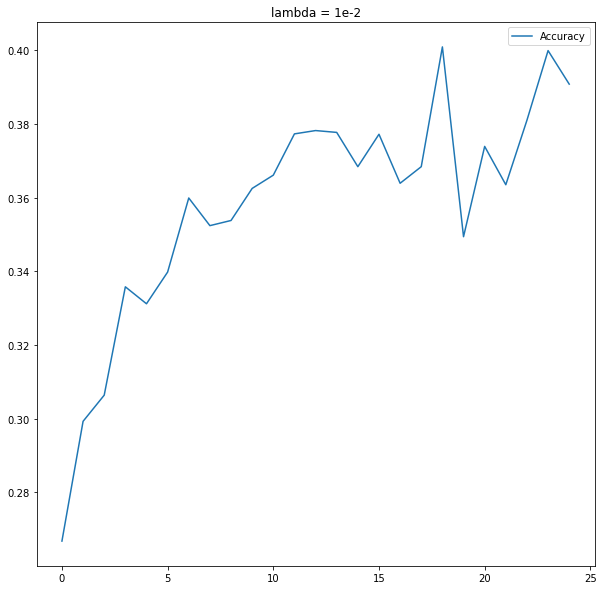

In [40]:
# create accuracy plot
def plot_accuracies(accuracies, title):
    plt.figure(figsize=(10, 10))

    plt.plot(accuracies, label="Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()

plot_accuracies(accuracies, "lambda = 1e-2")

# The accuracy of baseline network (lambda = 0) we could see that the accuracy is not that stable compare to the one above, also the value of accuracy is worse

In [41]:
num_neurons = (512, 512)
model = MLPClassifier(32*32*3, 10, num_neurons).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.95))

accuracies = np.zeros(25)

for epoch in range(25):
    odecay = 0
    train(model, train_dataloader, optimizer, odecay)
    accuracies[epoch] = accuracy(model, test_dataloader)
    print(f"{epoch=:<2} acc={accuracies[epoch]:.4f}")


epoch=0  acc=0.2768
epoch=1  acc=0.3015
epoch=2  acc=0.2572
epoch=3  acc=0.3176
epoch=4  acc=0.3104
epoch=5  acc=0.2708
epoch=6  acc=0.3027
epoch=7  acc=0.3187
epoch=8  acc=0.3068
epoch=9  acc=0.3175
epoch=10 acc=0.3382
epoch=11 acc=0.3222
epoch=12 acc=0.3265
epoch=13 acc=0.3332
epoch=14 acc=0.3238
epoch=15 acc=0.3126
epoch=16 acc=0.3232
epoch=17 acc=0.2939
epoch=18 acc=0.3310
epoch=19 acc=0.3411
epoch=20 acc=0.3146
epoch=21 acc=0.3107
epoch=22 acc=0.3288
epoch=23 acc=0.3063
epoch=24 acc=0.2889


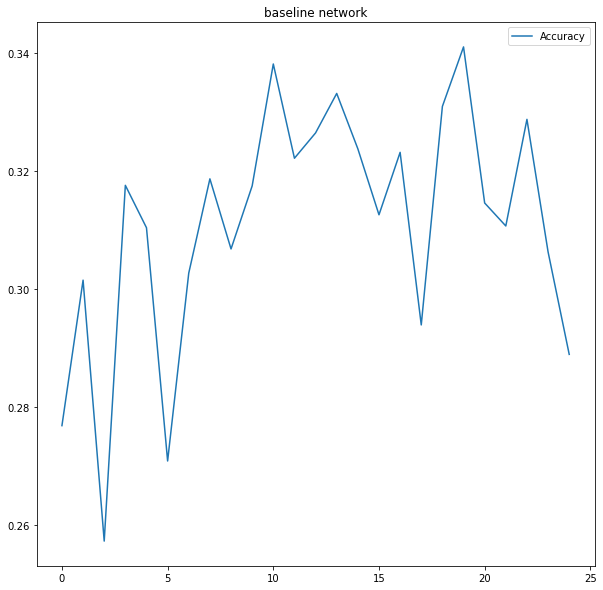

In [42]:
plot_accuracies(accuracies, "baseline network")